In [55]:
# Include the directory where COARE-algorithm is downloaded and its subfolders
import sys
sys.path.append('/home/jw8736/mlflux/COARE-algorithm/Python/COARE3.5/')
sys.path.append('/home/jw8736/mlflux/COARE-algorithm/Python/COARE3.6/')
from bulk import coare35vn
from coare36vn_zrf_et import coare36vn_zrf_et
from meteo import rhcalc

In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
ds = xr.load_dataset('../MLFLUXES/data/fluxes_all_cruises_compilation.nc')

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [5]:
ds_clean = ds.dropna(dim="time", how="any", 
                     subset=['taucx','taucy','hsc','hlc','U','tsnk','ta','qa'])

### Check that relative humidity makes sense 

In [13]:
# Example from aerobulk for xarray wrapper
# out_vars = xr.apply_ufunc(
#     skin_np,
#     sst,
#     t_zt,
#     hum_zt,
#     u_zu,
#     v_zu,
#     rad_sw,
#     rad_lw,
#     slp,
#     input_core_dims=[()] * 8,
#     output_core_dims=[()] * 6,
#     dask="parallelized",
#     kwargs=dict(
#         algo=algo, zt=zt, zu=zu, niter=niter, input_range_check=input_range_check
#     ),
#     output_dtypes=[sst.dtype]
#     * 6,  # deactivates the 1 element check which aerobulk does not like
# )

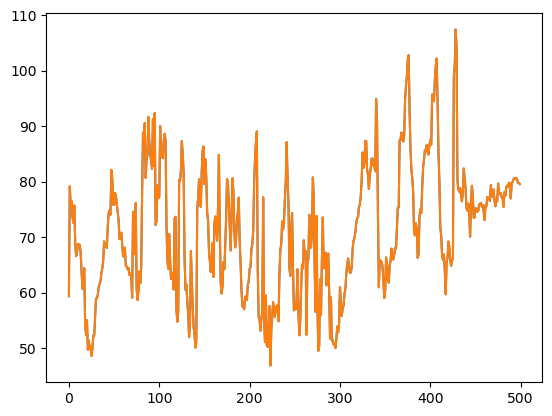

In [17]:
# Relative humidity
# For most of the points, temperature and humidity are measured at the same height so calculating
# relative humidity using reported temperature is ok
# rh: relative humidity
out_vars = xr.apply_ufunc(
    rhcalc,
    ds_clean.ta,
    ds_clean.dummy1,
    ds_clean.qa / 1000.,
    input_core_dims=[()] * 3,
    output_core_dims=[()] * 1,
    dask="parallelized",
    output_dtypes=[ds_clean.ta.dtype] * 1,  # deactivates the 1 element check which aerobulk does not like
)
plt.plot(out_vars[:500])
plt.plot(ds_clean.dummy2[:500])

### Calling COARE3.5

In [64]:
ti = 10
sst = ds_clean.isel(time=ti).tsnk.values  # sst in celsius 
t_zt = ds_clean.isel(time=ti).ta.values  # air temp. in celsius
hum_zt = ds_clean.isel(time=ti).qa.values / 1000.  # humidity, from g/kg to kg/kg
rh = ds_clean.isel(time=ti).dummy2.values  # relative humidity (don't know why it's called dummy2)
u_zu = ds_clean.isel(time=ti).U.values  # streamwise wind speed
v_zu = 0  # spanwise wind speed
zt = ds_clean.isel(time=ti).zt.values
zu = ds_clean.isel(time=ti).zu.values
rad_lw = ds_clean.isel(time=ti).rl.values
rad_sw = ds_clean.isel(time=ti).rs.values
print(sst, t_zt, rh, u_zu)

# sst = np.reshape(sst,(-1,1))
# t_zt = np.reshape(t_zt,(-1,1))
# hum_zt = np.reshape(hum_zt,(-1,1))
# u_zu = np.reshape(u_zu,(-1,1))
# v_zu = np.reshape(v_zu,(-1,1))
# zt = np.reshape(zt,(-1,1))
# zu = np.reshape(zu,(-1,1))
# slp = np.reshape(np.array([101000.0]),(-1,1))

11.874 7.33 68.780361 17.189


In [ ]:
list1 = [usr,tau,hsb,hlb,hlwebb,tsr,qsr,zot,zoq,Cd,Ch,Ce,L,zet]
list2 = [dter,dqer,tkt,RF,Cdn_10,Chn_10,Cen_10]

In [75]:
# Somehow zu, zt, and zq need to be cast into either int or float
list1 = coare35vn(u=u_zu, t=t_zt, rh=rh, ts=sst, P=1010, Rs=-rad_sw, Rl=-rad_lw, 
                  zu=float(zu), zt=float(zt), zq=float(zt), lat=45,
                  zi=600, rain=None, cp=None, sigH=None, jcool=0) # jcool=0, no cool skin correction


In [58]:
# u = ocean surface relative wind speed (m/s) at height zu(m)
# t = bulk air temperature (degC) at height zt(m)
# rh = relative humidity (%) at height zq(m)
# ts = sea water temperature (degC) - see jcool below
# P = surface air pressure (mb) (default = 1015)
# Rs = downward shortwave radiation (W/m^2) (default = 150)
# Rl = downward longwave radiation (W/m^2) (default = 370)
# zu = wind sensor height (m) (default = 18m)
# zt = bulk temperature sensor height (m) (default = 18m)
# zq = RH sensor height (m) (default = 18m)
# lat = latitude (default = 45 N)
# zi = PBL height (m) (default = 600m)
# rain = rain rate (mm/hr)
# cp = phase speed of dominant waves (m/s)
# sigH =  significant wave height (m)
# jcool = cool skin option (default = 1 for bulk SST)

In [76]:
print(list1[0][1], ds_clean.isel(time=ti).taub.values)
print(list1[0][2], ds_clean.isel(time=ti).hsb.values)
print(list1[0][3], ds_clean.isel(time=ti).hlb.values)

0.6650365336236539 0.6222
104.24374157633584 109.52
241.53214502900397 238.65


### COARE3.5 for xarray

In [91]:
# For now only running a for loop
tau_t = []; qh_t = []; qe_t = []
for ti in range(len(ds_clean.U.values)):
    sst = ds_clean.isel(time=ti).tsnk.values  # sst in celsius 
    t_zt = ds_clean.isel(time=ti).ta.values  # air temp. in celsius
    hum_zt = ds_clean.isel(time=ti).qa.values / 1000.  # humidity, from g/kg to kg/kg
    rh = ds_clean.isel(time=ti).dummy2.values  # relative humidity (don't know why it's called dummy2)
    u_zu = ds_clean.isel(time=ti).U.values  # streamwise wind speed
    v_zu = 0  # spanwise wind speed
    zt = ds_clean.isel(time=ti).zt.values
    zu = ds_clean.isel(time=ti).zu.values
    rad_lw = ds_clean.isel(time=ti).rl.values
    rad_sw = ds_clean.isel(time=ti).rs.values
    outputs = coare35vn(u=u_zu, t=t_zt, rh=rh, ts=sst, P=1010, Rs=-rad_sw, Rl=-rad_lw, 
                  zu=float(zu), zt=float(zt), zq=float(zt), lat=45,
                  zi=600, rain=None, cp=None, sigH=None, jcool=0) # jcool=0, no cool skin correction
    tau = outputs[0][1]; tau_t.append(tau)
    qh = outputs[0][2]; qh_t.append(qh)
    qe = outputs[0][3]; qe_t.append(qe)

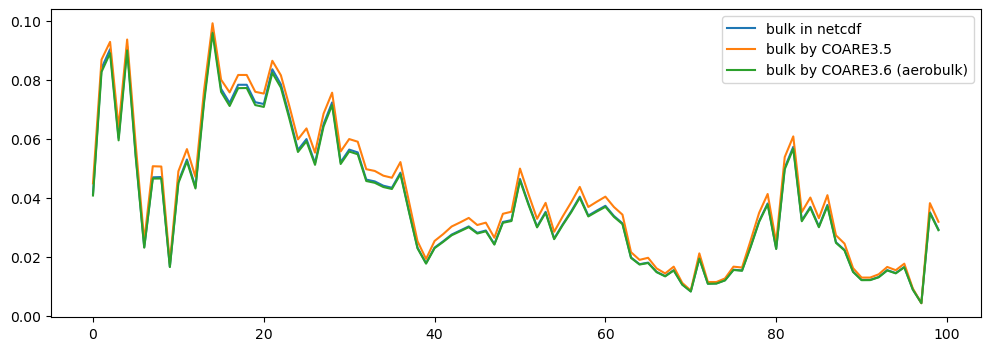

In [90]:
fig = plt.figure(figsize=[12,4])
plt.plot(tau_t[500:600], label='bulk in netcdf')
plt.plot(ds_clean.taub[500:600], label='bulk by COARE3.5')

from aerobulk.flux import noskin_np, skin_np, noskin, skin
ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='coare3p6', zt=ds_clean.zt, 
                                zu=ds_clean.zu)
plt.plot(taux[500:600], label='bulk by COARE3.6 (aerobulk)') # display first 100 points

plt.legend()